# **The Story of Civilization - Volume 1 - Book One**

In [320]:
!pip install wordcloud


In [321]:
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

##Look at the data
It's from the book "The Story of Civilization" by Will Durant. Here I used book one part from the first volume of the book. It tells about the history of "Near East" from Sumeria and Egypt to Persia.
Data is obtained from the .xml format of the book, available on https://archive.org/download/TheStoryOfCivilizationcomplete

In [322]:
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

book_text = read_file('BookOne.txt')
print(book_text[0:1303])

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE DjVuXML>
<DjVuXML>
<BODY>
<OBJECT data="file://localhost//var/tmp/autoclean/derive/TheStoryOfCivilizationcomplete//Durant_Will_-_The_story_of_civilization_1.djvu" height="5667" type="image/x.djvu" usemap="Durant_Will_-_The_story_of_civilization_1_0214.djvu" width="3742">
<PARAM name="PAGE" value="Durant_Will_-_The_story_of_civilization_1_0214.djvu"/>
<PARAM name="DPI" value="600"/>
<HIDDENTEXT>
<PAGECOLUMN>
<REGION backgroundColor="65793" inverted="true">
<PARAGRAPH>
<LINE>
<WORD coords="1721,1153,2181,1104,1152">CHAPTER</WORD>
<WORD coords="2228,1154,2371,1107,1153">VII</WORD>
</LINE>
</PARAGRAPH>
</REGION>
</PAGECOLUMN>
<PAGECOLUMN>
<REGION backgroundColor="0" inverted="true">
<PARAGRAPH>
<LINE>
<WORD coords="1755,1447,2351,1315,1445">Sumeria</WORD>
</LINE>
</PARAGRAPH>
<PARAGRAPH>
<LINE>
<WORD coords="929,1677,1469,1605,1676">Orient-ation—</WORD>
<WORD coords="1475,1681,1999,1607,1679">Contributions</WORD>
<WORD coords="2033,1701,2113

As we can see, the data has tags with an hierarchy like this:

BODY -> OBJECT -> HIDDENTEXT -> PAGECOLUMN -> PARAGRAGH -> LINE -> WORD

There's one BODY tag at all. Each page is in a OBJECT tag inside BODY and there's a MAP tag between pages. Pages can have header, main center part and a footer. Each of them are in different PAGECOLUMN tags. Other remaining tags are obvious!

Note that the data is obtained by OCR from the book. Hence some characters may be recognized wrong.

# Extract chapters' hierarchy from the book using regex & patterns


In [323]:
subsection_pattern = r'^(I|II|III|IV|V|VI|VII|VIII|IX|X|XI|XII|XIII|XIV|XV). [A-Z\s\.\-,]+$'
section_pattern = r'^(CHAPTER .*)$'

def extract_book_titles(text):
    lines = re.split(r'<LINE>', text)
    chapters_dict = {}

    last_section = ''
    last_subsection = ''
    for line in lines:
        words = re.findall(r'<WORD.*?>(.*?)<\/WORD>', line, re.DOTALL)
        words_in_line = ' '.join(words)

        #correct the typo caused by OCR
        if words_in_line.startswith("n."):
            words_in_line = "II." + words_in_line[2:]
        if words_in_line.startswith("HI."):
            words_in_line = "III." + words_in_line[3:]

        # look for section/subsection patterns in the text
        if re.match(section_pattern, words_in_line):
          last_section = words_in_line
          last_subsection = 'a_new_section'
        elif(last_section != '' and last_subsection == 'a_new_section'):
          last_section = last_section + ' ' + words_in_line
          chapters_dict[last_section] = {}
          last_subsection = ''
          print(f"{last_section}")
        elif re.match(subsection_pattern, words_in_line):
          chapters_dict[last_section][words_in_line] = ''
          last_subsection = words_in_line
          print(f"    {words_in_line}")
        else:
          if(last_section != '' and last_subsection != ''):
            current_lines_added = chapters_dict[last_section][last_subsection]
            chapters_dict[last_section][last_subsection] = current_lines_added + ' ' + words_in_line
    return chapters_dict

In [324]:
print('Titles Hirearchy:')
chapters_dict = extract_book_titles(book_text)

print()
print('Book divided by chpaters:')
for key, value in chapters_dict.items():
    print(f'{key}:')
    for key2, value2 in chapters_dict[key].items():
      print(f'    {key2}: {value2[0:100]}...')

Titles Hirearchy:
CHAPTER VII Sumeria
    I. ELAM
    II. THE SUMERIANS
    III. PASSAGE TO EGYPT
CHAPTER VIII Egypt
    I. THE GIFT OF THE NILE
    II. THE MASTER BUILDERS
    III. THE CIVILIZATION OF EGYPT
    IV. THE HERETIC KING
    V. DECLINE AND FALL
CHAPTER IX Babylonia
    I. FROM HAMMURABI TO NEBUCHADREZZAR
    II. THE TOILERS
    III. THE LAW
    IV. THE GODS OF BABYLON
    V. THE MORALS OF BABYLON
    VI. LETTERS AND LITERATURE
    VII. ARTISTS
    VIII. BABYLONIAN SCIENCE
    IX. PHILOSOPHERS
    X. EPITAPH
CHAPTER X Assyria
    I. CHRONICLES
    II. ASSYRIAN GOVERNMENT
    III. ASSYRIAN LIFE
    IV. ASSYRIAN ART
    V. ASSYRIA PASSES
CHAPTER XI A Motley of Nations
    I. THE INDO-EUROPEAN PEOPLES
    II, THE SEMITIC PEOPLES
CHAPTER XII Judea
    I. THE PROMISED LAND
    II. SOLOMON IN ALL HIS GLORY
    III. THE GOD OF HOSTS
    IV. THE FIRST RADICALS
    V. THE DEATH AND RESURRECTION OF JERUSALEM
    VI. THE PEOPLE OF THE BOOK
    VII. THE LITERATURE AND PHILOSOPHY OF THE 

# Preprocessing


##Some statistics about number of sentences in the text

In [325]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

chapter_sentences = {}
for key, value in chapters_dict.items():
    chapter_sentences[key] = []
    for key2, value2 in chapters_dict[key].items():
      num = sent_tokenize(value2)
      chapter_sentences[key].append(num)

print("Number of sentences in each chapter:")
for key, value in chapter_sentences.items():
    sent_num = 0
    for value2 in chapter_sentences[key]:
      sent_num += len(value2)
    print(f"{key}: {sent_num}")

Number of sentences in each chapter:
CHAPTER VII Sumeria: 319
CHAPTER VIII Egypt: 1428
CHAPTER IX Babylonia: 821
CHAPTER X Assyria: 316
CHAPTER XI A Motley of Nations: 195
CHAPTER XII Judea: 1015
CHAPTER XIII Persia: 522


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Tokenization, Normalization, etc.

In [326]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string

def normalize_text(text, given_stopwords):
    # Lowercase conversion
    normalized_text = text.lower()

    #Remove words that are not in the main text body
    words_to_remove = ['(chap', 'chap.', 'chap,', 'the story of civilization']
    for word in words_to_remove:
      normalized_text = normalized_text.replace(word, '')

    # Tokenization
    normalized_text = nltk.word_tokenize(normalized_text)

    #Stopword removal
    stopwords = [x.lower() for x in nltk.corpus.stopwords.words('english')]
    normalized_text=[word for word in normalized_text if (word.lower() not in stopwords) and (word.lower() not in given_stopwords)]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    normalized_text = [lemmatizer.lemmatize(token, wordnet.VERB) for token in normalized_text]

    # Punctuation removal
    punctuations = string.punctuation + '—' + '“' + '”'
    normalized_text=[word for word in normalized_text if (word not in punctuations) and (len(word)>= 3)]


    return normalized_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Display modified text

In [327]:
normalized_dict = {}
civilization_names = {
    'Sumeria': ['sumeria', 'sumerian', 'one'],
    'Egypt': ['egypt', 'egyptian', 'one'],
    'Babylonia': ['babylonia', 'babylonian', 'babylon', 'one'],
    'Assyria': ['assyria', 'assyrian', 'one'],
    'A Motley of Nations': ['one'],
    'Judea': ['judea', 'jew', 'jews', 'one'],
    'Persia': ['persia', 'persian', 'one']
}
for key, value in chapters_dict.items():
    new_key = " ".join(key.split()[2:])
    normalized_dict[new_key] = []
    for key2, value2 in chapters_dict[key].items():
      ntxt = normalize_text(key2 + ' ' + value2, civilization_names[new_key])
      normalized_dict[new_key].extend(ntxt)

In [328]:
print('Data overview:')
for key, value in normalized_dict.items():
    print(f'{key}: {value[0:20]}...')

Data overview:
Sumeria: ['elam', 'culture', 'susa—', 'potter', 'wheel—', 'wagon-wheel', 'reader', 'look', 'map', 'persia', 'run', 'finger', 'north', 'along', 'tigris', 'persian', 'gulf', 'amara', 'east', 'across']...
Egypt: ['gift', 'nile', 'delta', 'alexandria—', 'nile—', 'pyramids—', 'sphinx', 'perfect', 'harbor', 'outside', 'long', 'breakwater', 'wave', 'topple', 'another', 'roughly', 'within', 'sea', 'silver', 'mirror']...
Babylonia: ['hammurabi', 'nebuchadrezzar', 'contributions', 'modem', 'civilization—', 'land', 'be-', 'tween', 'rivers', 'hammurabi', 'capital', 'kassite', 'domination—', 'amarna', 'letters—', 'assyrian', 'con-', 'quest—', 'ebuchadrezzar—', 'days']...
Assyria: ['chronicle', 'beginnings', 'cities', 'race', '—the', 'conquerors', 'sennacherib', 'esarhaddon', 'sardanapalus', 'eanwhile', 'three', 'hundred', 'miles', 'north', 'babylon', 'another', 'civilization', 'appear', 'force', 'maintain']...
A Motley of Nations: ['indo-european', 'people', 'ethnic', 'scene—', 'mita

# Compare civilizations and find keywords

## general comparison (number of words, unique words, etc.)

In [329]:
for chapter_title, chapter_tokens in normalized_dict.items():
  print(chapter_title + ':')
  print (f'# of words: {len(chapter_tokens)}')
  print (f'# of unique words: {len(set(chapter_tokens))}')
  avg = np.sum([len(word) for word in chapter_tokens])/len(chapter_tokens)
  print (f'Average word length: {avg}')
  print()

Sumeria:
# of words: 4559
# of unique words: 2271
Average word length: 6.133362579513051

Egypt:
# of words: 17624
# of unique words: 5768
Average word length: 5.966182478438493

Babylonia:
# of words: 10236
# of unique words: 4075
Average word length: 5.992379835873388

Assyria:
# of words: 4421
# of unique words: 2302
Average word length: 6.141370730603936

A Motley of Nations:
# of words: 3148
# of unique words: 1743
Average word length: 6.1810673443456166

Judea:
# of words: 11655
# of unique words: 4308
Average word length: 5.963620763620764

Persia:
# of words: 8332
# of unique words: 3547
Average word length: 6.128060489678348



## WordCloud

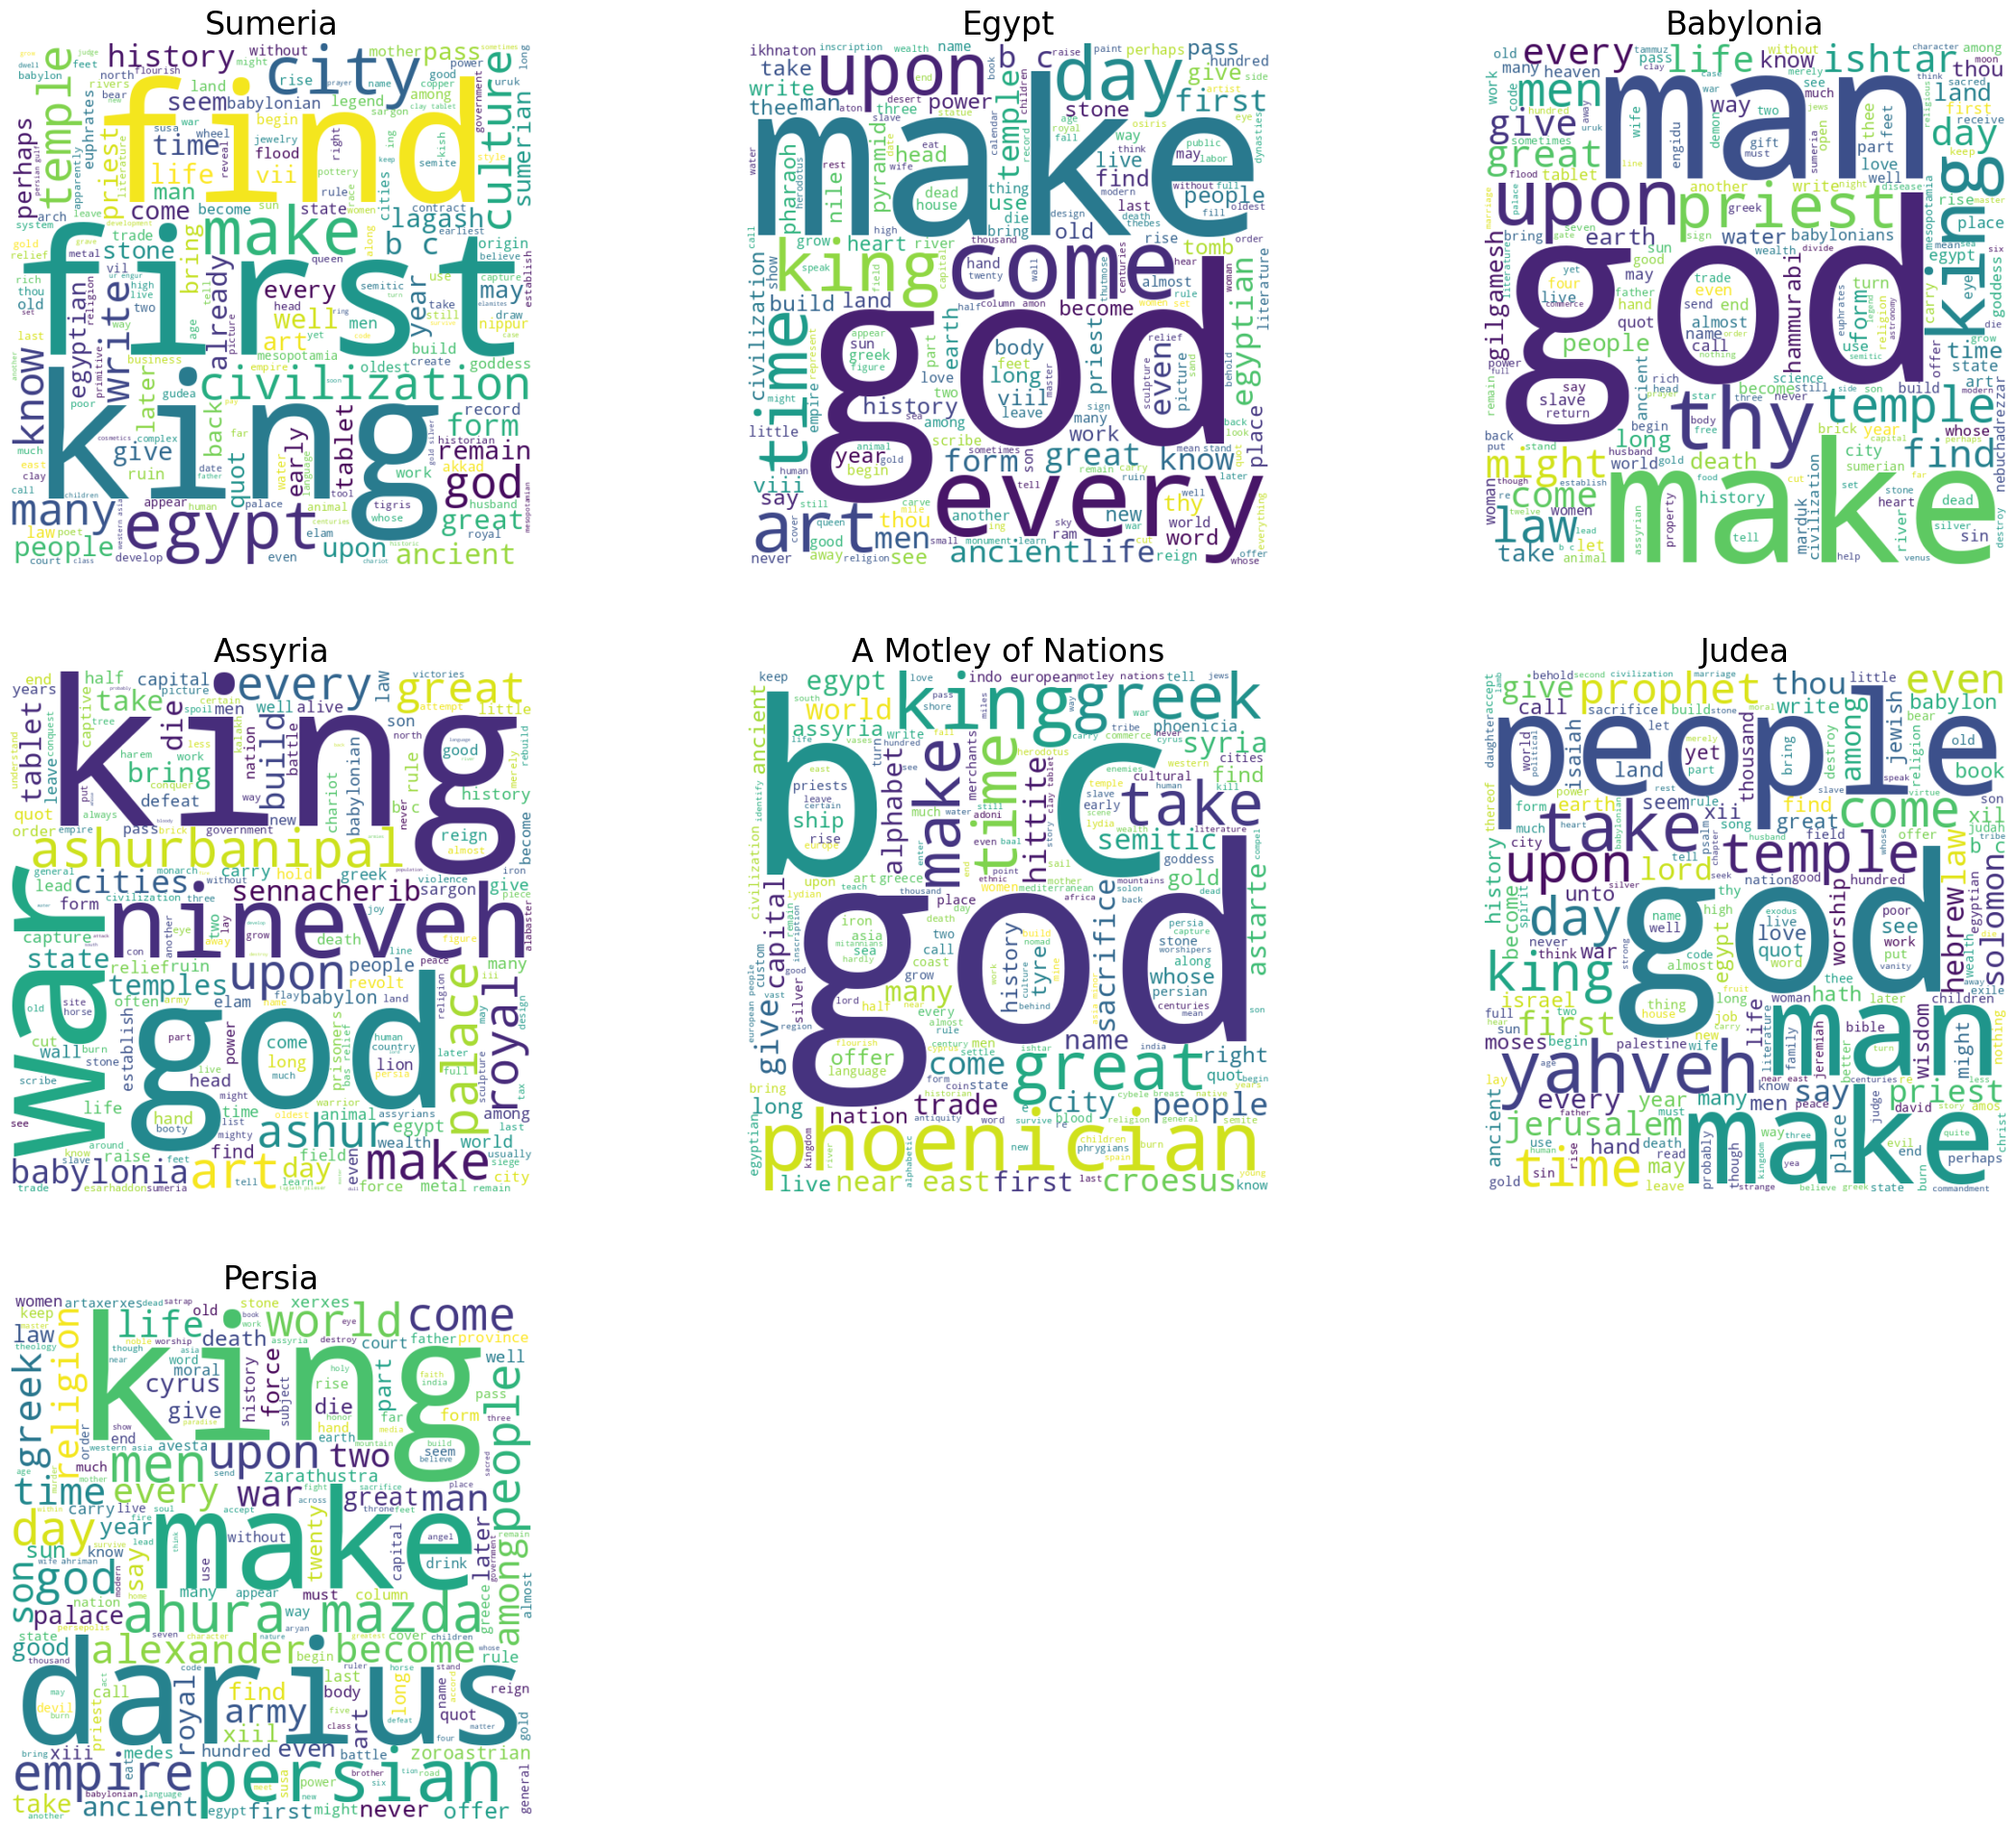

In [330]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

counter = 1
plt.figure(figsize=(28, 24))
num_rows = 3
num_cols = 3

for key, value in normalized_dict.items():
    chapter_text = ','.join(word for word in value )
    wordcloud = WordCloud(width=600, height=600, background_color='white').generate(chapter_text)
    plt.subplot(num_rows, num_cols, counter)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(key, fontsize=24)
    counter += 1
plt.show()


Intersting! In each civilization, there were some highlights. In a glance, we can see "god" is bold in some civilizations and "war" in some others. So let's see if we can find out more ... :)

## Classify topics in text

Let's consider some areas. Find out related words for each of them and then search them in all chapters in order to classify and assign a probability to each chapter-area.
We considered 4 classes: religion, art, science, war

In [331]:
def get_related_words_list(word, given_related_words):
  synsets = wordnet.synsets(word)
  related_words = []

  # Add related words (synonyms)
  for synset in synsets:
      related_words.extend([lemma.name() for lemma in synset.lemmas()])

  # Add hyponyms
  for synset in synsets:
      for hyponym in synset.hyponyms():
          related_words.extend([lemma.name() for lemma in hyponym.lemmas()])

  # Remove the extra part
  related_words = [word.split('.')[0] for word in related_words]

  related_words = [word.replace('_', '-') for word in related_words]

  unique_list = []
  [unique_list.append(x.lower()) for x in related_words if x.lower() not in unique_list]

  return unique_list

I searched on the web to find packages for related words but at the end, I decided to use Wordnet. Since it's a comprehensive resource and the relevance between our word and the new related word is clear. it's hyponym for example.

I will then add some manual words to the lists as well to make them richer:

In [332]:
religion_words = [
    "Faith", "Belief", "Spirituality", "Worship", "Prayer",
    "Religion", "Devotion", "God", "Church", "Scripture",
    "Sacred", "Ritual", "Reverence", "Clergy", "Prophet",
    "Holy", "Theology", "Temple", "Messiah", "Faithful"
]

art_words = [
    "Creativity", "Expression", "Aesthetics", "Imagination", "Beauty",
    "Visual", "Painting", "Sculpture", "Music", "Literature",
    "Masterpiece", "Gallery", "Composition", "Canvas", "Performance",
    "Artistic", "Creativity", "Culture", "Design", "Sculptor"
]

science_words = [
    "Knowledge", "Research", "Experiment", "Discovery", "Scientist",
    "Hypothesis", "Observation", "Data", "Theory", "Experimentation",
    "Laboratory", "Innovation", "Physics", "Biology", "Chemistry",
    "Astronomy", "Technology", "Researcher", "Scientific", "Analysis"
]

war_words = [
    "Conflict", "Battle", "Combat", "Soldier", "Warfare",
    "Strategy", "Troops", "Weapon", "Military", "Victory",
    "Casualty", "Tactic", "Armament", "Armored", "Alliance",
    "Campaign", "Enemy", "Siege", "Resistance", "Conquest"
]


all_classes_related_words = {
    'religion': get_related_words_list('religion', religion_words),
    'art': get_related_words_list('art', art_words),
    'science': get_related_words_list('science', science_words),
    'war': get_related_words_list('war', war_words)
}

for label, keywords in all_classes_related_words.items():
  print(f'{label}: {keywords}')

religion: ['religion', 'faith', 'religious-belief', 'organized-religion', 'apophatism', 'bahaism', 'brahmanism', 'brahminism', 'buddhism', 'cataphatism', 'christianity', 'christian-religion', 'cult', 'cultus', 'religious-cult', 'doctrine-of-analogy', 'analogy', 'ecclesiasticism', 'hinduism', 'hindooism', 'jainism', 'manichaeism', 'manichaeanism', 'mithraism', 'mithraicism', 'mysticism', 'religious-mysticism', 'nature-worship', 'paganism', 'pagan-religion', 'heathenism', 'revealed-religion', 'shamanism', 'asian-shamanism', 'shinto', 'shintoism', 'sikhism', 'taoism', 'hsuan-chiao', 'theism', 'wicca', 'zoroastrianism', 'mazdaism', 'church', 'christian-church', 'established-church', 'judaism', 'hebraism', 'jewish-religion', 'khalsa', 'scientology', 'church-of-scientology', 'sect', 'religious-sect', 'religious-order']
art: ['art', 'fine-art', 'artistic-creation', 'artistic-production', 'artistry', 'prowess', 'artwork', 'graphics', 'nontextual-matter', 'artificial-flower', 'commercial-art', 

In [333]:
chapter_class_probabilities = {}
for chapter_title, chapter_content in normalized_dict.items():
    probabilities = {}
    for class_name, keywords in all_classes_related_words.items():
        keyword_count = sum(1 for keyword in keywords if keyword in chapter_content)
        probabilities[class_name] = keyword_count / len(keywords)
    chapter_class_probabilities[chapter_title] = probabilities

for chapter_title, probabilities in chapter_class_probabilities.items():
    print(chapter_title, ':', probabilities)

Sumeria : {'religion': 0.05454545454545454, 'art': 0.07017543859649122, 'science': 0.05714285714285714, 'war': 0.03571428571428571}
Egypt : {'religion': 0.09090909090909091, 'art': 0.10526315789473684, 'science': 0.14285714285714285, 'war': 0.03571428571428571}
Babylonia : {'religion': 0.09090909090909091, 'art': 0.07017543859649122, 'science': 0.11428571428571428, 'war': 0.07142857142857142}
Assyria : {'religion': 0.03636363636363636, 'art': 0.05263157894736842, 'science': 0.08571428571428572, 'war': 0.03571428571428571}
A Motley of Nations : {'religion': 0.01818181818181818, 'art': 0.03508771929824561, 'science': 0.02857142857142857, 'war': 0.03571428571428571}
Judea : {'religion': 0.10909090909090909, 'art': 0.10526315789473684, 'science': 0.08571428571428572, 'war': 0.03571428571428571}
Persia : {'religion': 0.09090909090909091, 'art': 0.08771929824561403, 'science': 0.08571428571428572, 'war': 0.03571428571428571}


In [334]:
def draw_civilization_areas_plot(chapter_class_probabilities):
  civilizations = ["Sumeria", "Egypt", "Babylonia", "Assyria", "A Motley of Nations", "Judea", "Persia"]
  classes = ['religion', 'art', 'science', 'war']

  width = 0.2
  x = range(len(civilizations))

  fig, ax = plt.subplots(figsize=(12, 6))

  for i, class_name in enumerate(classes):
      class_prob = [chapter_class_probabilities[civilization][class_name] for civilization in civilizations]
      plt.bar([pos + width * i for pos in x], class_prob, width, label=class_name)

  plt.xlabel('Civilizations')
  plt.ylabel('Class Probabilities')
  plt.title('Class Probabilities Among Different Civilizations')
  plt.xticks([pos + width * 1.5 for pos in x], civilizations)
  plt.legend(loc='upper right')
  plt.grid(True, axis='y')

  plt.show()

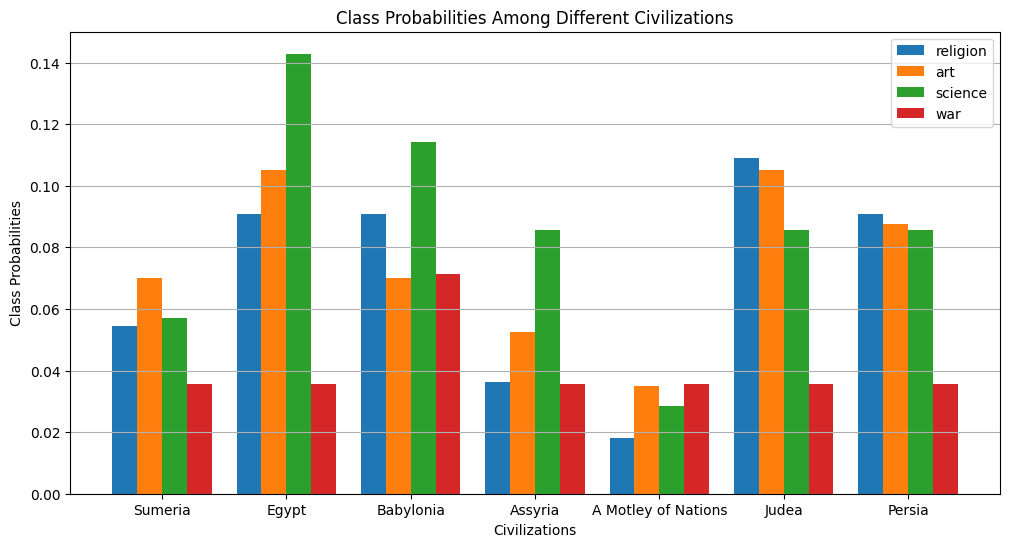

In [335]:
draw_civilization_areas_plot(chapter_class_probabilities)

I plotted this and after analyzing a bit, I noticed that the fifth category (A Montley of Nations) bars were all lower that other ones for example egypt. I then realized that for calculating probabilities, I did this:

probabilities[class_name] = keyword_count / len(keywords)

while it has a bug. The longer the chapter, the probability will tend to become higher since key word matches will probably be more. So that the comparison is valid just within a chapter. For example to state that in egypt, science area was mentioned more rather than religion or art. Still we can't compare this to other chapters.

Now an idea is to divide keyword_count by the length of the text not the length of the keywords.

In [336]:
chapter_class_probabilities_improved = {}
for chapter_title, chapter_content in normalized_dict.items():
    probabilities = {}
    for class_name, keywords in all_classes_related_words.items():
        keyword_count = sum(1 for keyword in keywords if keyword in chapter_content)
        probabilities[class_name] = keyword_count / (len(keywords)*len(chapter_content))
    chapter_class_probabilities_improved[chapter_title] = probabilities

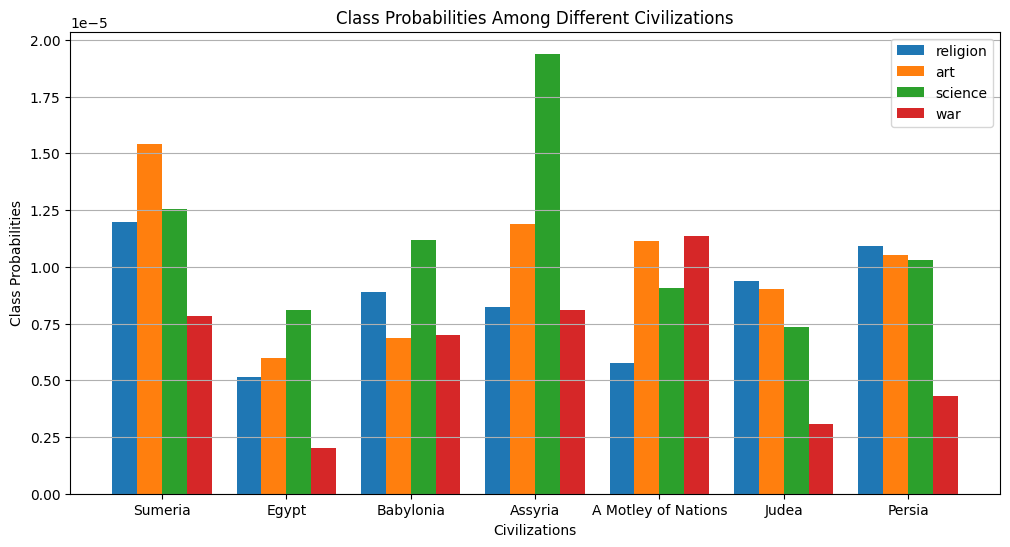

In [337]:
draw_civilization_areas_plot(chapter_class_probabilities_improved)

Yes! wordclouds and these bar charts are completing each other. We can see overall science and art were popular in all of the ages. Also in each chapter, we can check separately. For example war related topics in other nations, were more mentioned that other topics. In egypt, it was reversed. Science and art is highlighted. It also worths to note that persia is the civilization that 'religion' related words occured more that other fields. There's also another group like this ... Judea! Those are the groups that 'religion' seems important to them. This lasted until even now ... Isn't it :)

## Test a preprocessing step effect

Let's delete the given stopwords list that we were using to delete unnecessary terms:

In [338]:
normalized_dict = {}

for key, value in chapters_dict.items():
    new_key = " ".join(key.split()[2:])
    normalized_dict[new_key] = []
    for key2, value2 in chapters_dict[key].items():
      ntxt = normalize_text(key2 + ' ' + value2, [])
      normalized_dict[new_key].extend(ntxt)

And see the result in wordCloud part:

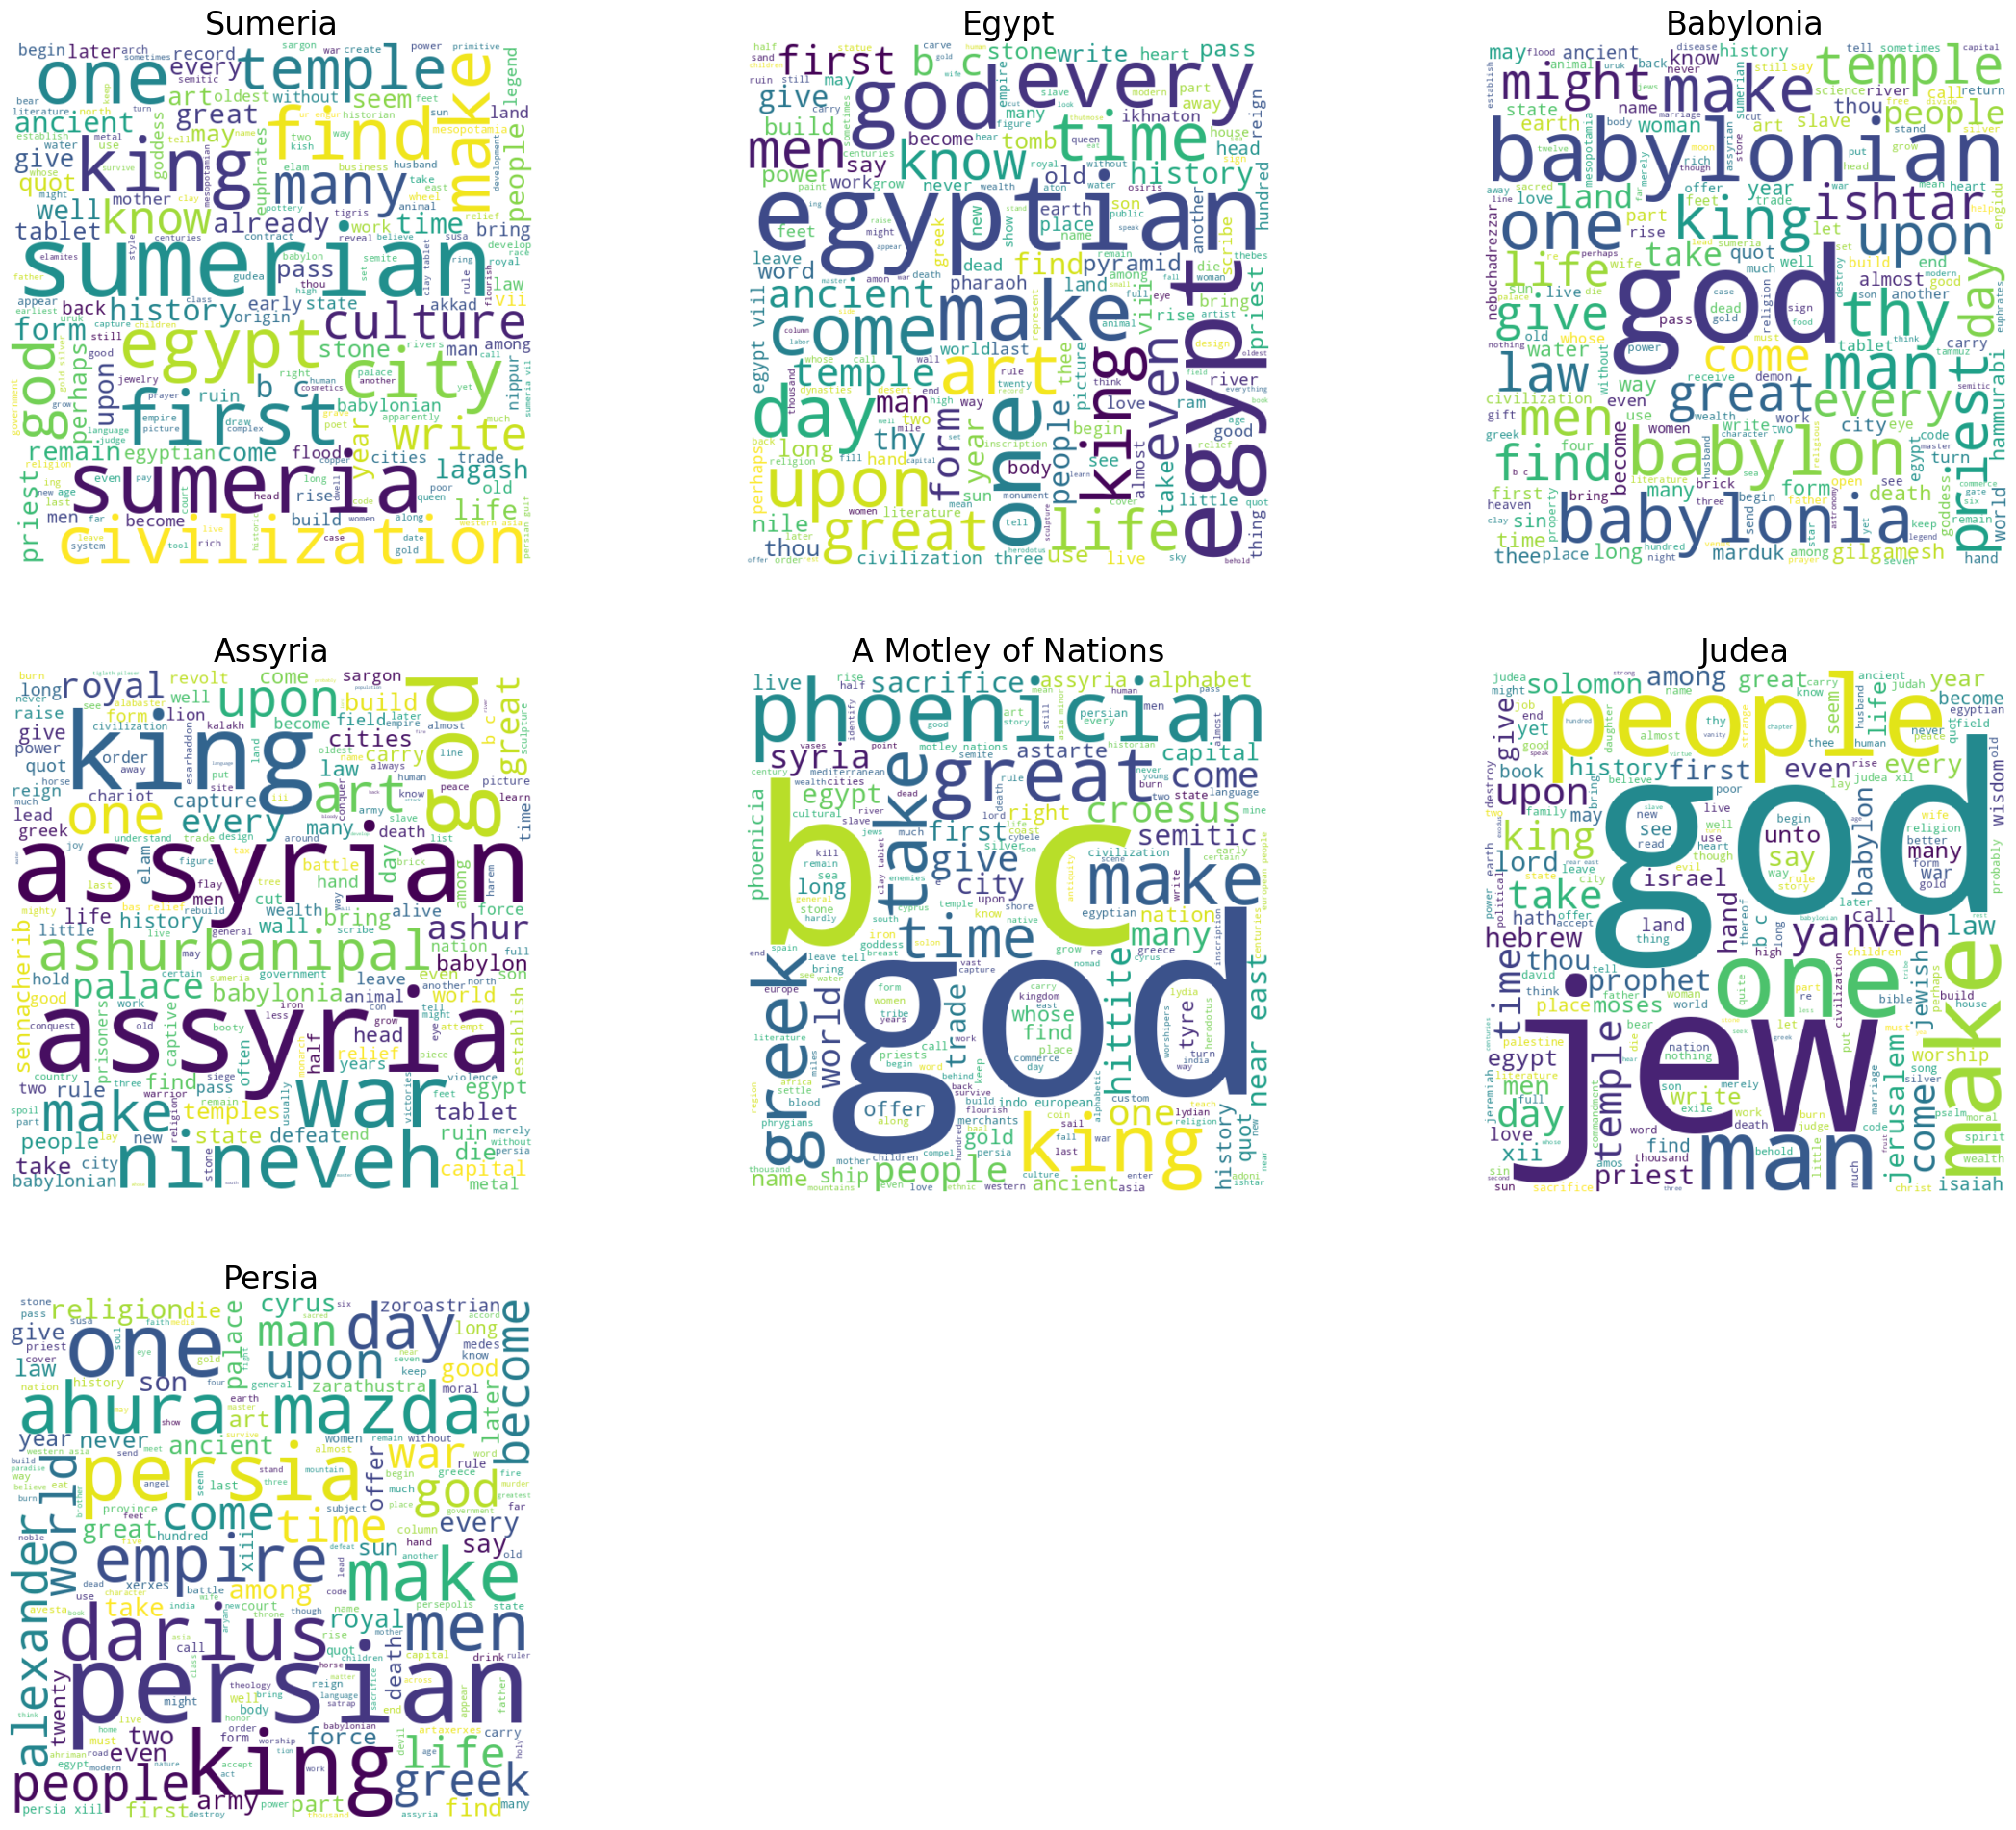

In [339]:
counter = 1
plt.figure(figsize=(28, 24))
num_rows = 3
num_cols = 3

for key, value in normalized_dict.items():
    chapter_text = ','.join(word for word in value )
    wordcloud = WordCloud(width=600, height=600, background_color='white').generate(chapter_text)
    plt.subplot(num_rows, num_cols, counter)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(key, fontsize=24)
    counter += 1
plt.show()

As you can see, this time the wordclouds have become more diffused and less informative since that list were really stopwords that were not really important.

Now for example words like persian & persia are the biggest terms in the "Persia" wordcloud which is not that much